In [ ]:
# 참고 : https://www.kaggle.com/andrewmvd/covid-19-ct-scans-getting-started

In [11]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# 1.먼저 본인의 Kaggle 계정에서 API Token 을 다운받습니다.(kaggle.json)
# 2.Kaggle API를 설치합니다.
!pip install kaggle   
# 3.kaggle.json 파일을 VM에 업로드 합니다.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"briansong7272","key":"05bcb4a34f899140cce615a6c3c7d225"}'}

In [3]:
# 4.파일이 재대로 업로드 됐는지 확인
!ls -1ha kaggle.json

kaggle.json


In [4]:
# 5.Kaggle API 가 Token을 사용하게 하기 위해 kaggle.json 파일을 ~/.kaggle로 이동 시킵니다.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# 6. Permission Warning 이 일어나지 않도록 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# 7.Kaggle 에서 chest-xray dataset을 다운 받기 위해 API Command 를 복사해서 가져옵니다.
# dataset URL : https://www.kaggle.com/andrewmvd/covid19-ct-scans
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 98% 1.02G/1.03G [00:18<00:00, 30.0MB/s]
100% 1.03G/1.03G [00:18<00:00, 58.9MB/s]


In [6]:
# 압축파일 해제
from zipfile import ZipFile

with ZipFile('covid19-ct-scans.zip') as z: 
    z.extractall()

In [15]:
!mkdir  /content/gdrive/My\ Drive/CV/COVID-19\ CT/input/covid19-ct-scans

In [16]:
!cp -r ct_scans /content/gdrive/My\ Drive/CV/COVID-19\ CT/input/covid19-ct-scans
!cp -r lung_mask /content/gdrive/My\ Drive/CV/COVID-19\ CT/input/covid19-ct-scans
!cp -r infection_mask /content/gdrive/My\ Drive/CV/COVID-19\ CT/input/covid19-ct-scans
!cp -r lung_and_infection_mask /content/gdrive/My\ Drive/CV/COVID-19\ CT/input/covid19-ct-scans

In [18]:
!cp metadata.csv /content/gdrive/My\ Drive/CV/COVID-19\ CT/input/covid19-ct-scans

In [19]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt

In [27]:
# Read and examine metadata
raw_data = pd.read_csv("/content/gdrive/My Drive/CV/COVID-19 CT/input/covid19-ct-scans/metadata.csv")

raw_data['ct_scan'] = raw_data['ct_scan'].str.slice_replace(start=0, stop=2, repl="/content/gdrive/My Drive/CV/COVID-19 CT")
raw_data['lung_mask'] = raw_data['lung_mask'].str.slice_replace(start=0, stop=2, repl="/content/gdrive/My Drive/CV/COVID-19 CT")
raw_data['infection_mask'] = raw_data['infection_mask'].str.slice_replace(start=0, stop=2, repl="/content/gdrive/My Drive/CV/COVID-19 CT")
raw_data['lung_and_infection_mask'] = raw_data['lung_and_infection_mask'].str.slice_replace(start=0, stop=2, repl="/content/gdrive/My Drive/CV/COVID-19 CT")

raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
14,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...
13,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...
5,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...
19,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...
10,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...,/content/gdrive/My Drive/CV/COVID-19 CT/input/...


In [28]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [29]:
# Read sample
sample_ct   = read_nii(raw_data.loc[0,'ct_scan'])
sample_lung = read_nii(raw_data.loc[0,'lung_mask'])
sample_infe = read_nii(raw_data.loc[0,'infection_mask'])
sample_all  = read_nii(raw_data.loc[0,'lung_and_infection_mask'])

In [30]:
# Examine Shape
sample_ct.shape

(512, 512, 301)

In [39]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(22,18))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('CT Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')

    plt.show()

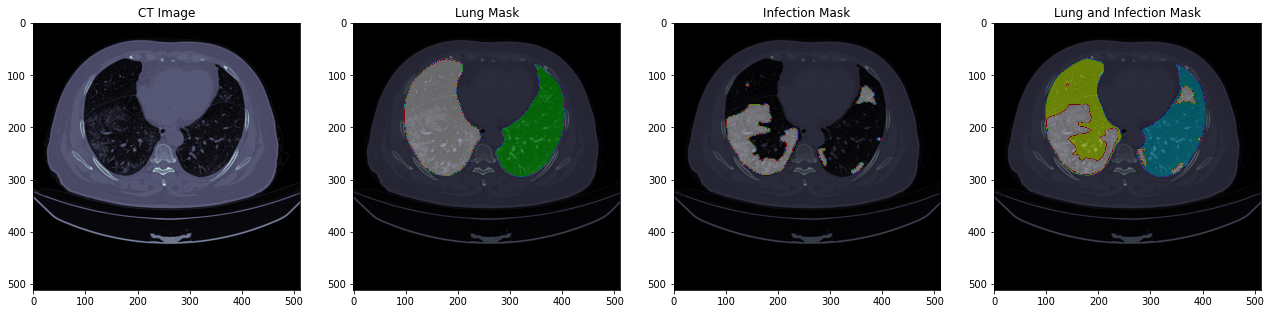

In [40]:
# Examine one slice of a ct scan and its annotations
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])

In [41]:
def bulk_plot_sample(array_list, index_list):
    '''
    Plots multiple slices, wrapper of plot_sample
    '''
    for index_value in index_list:
        plot_sample([array_list[0][...,index_value], array_list[1][...,index_value], array_list[2][...,index_value], array_list[3][...,index_value]])

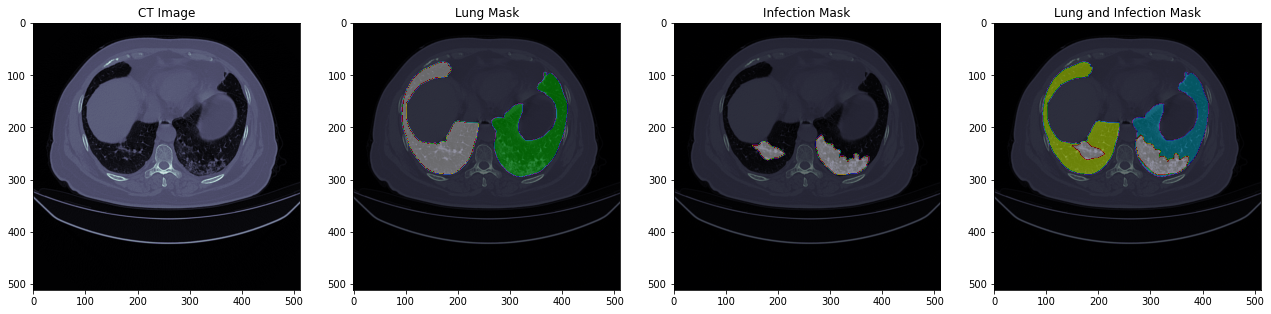

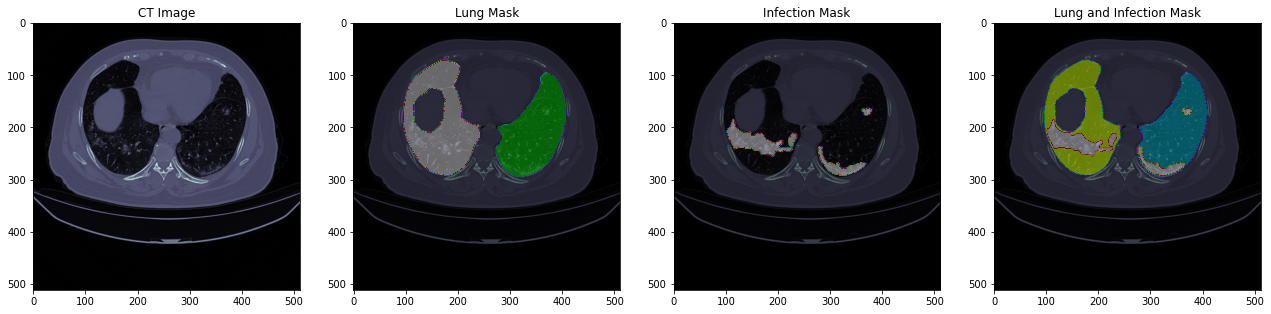

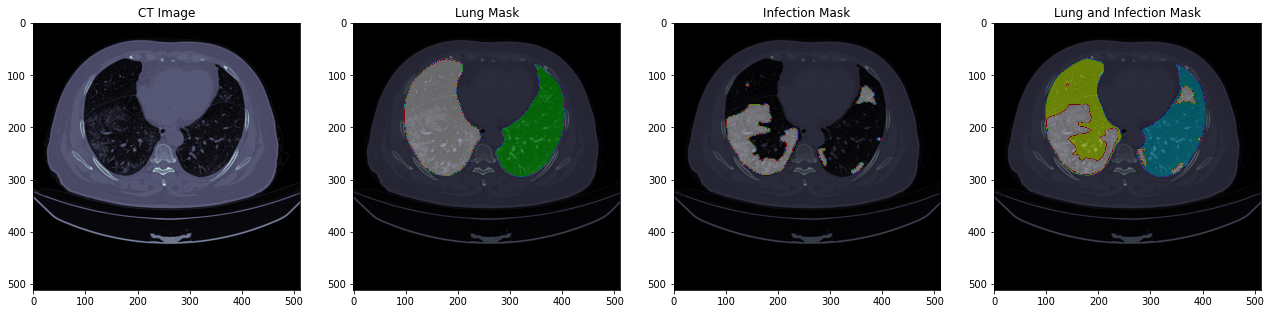

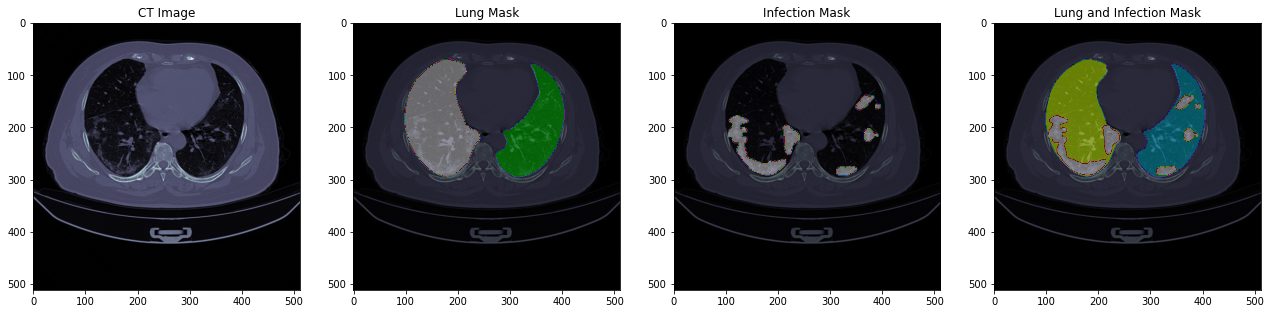

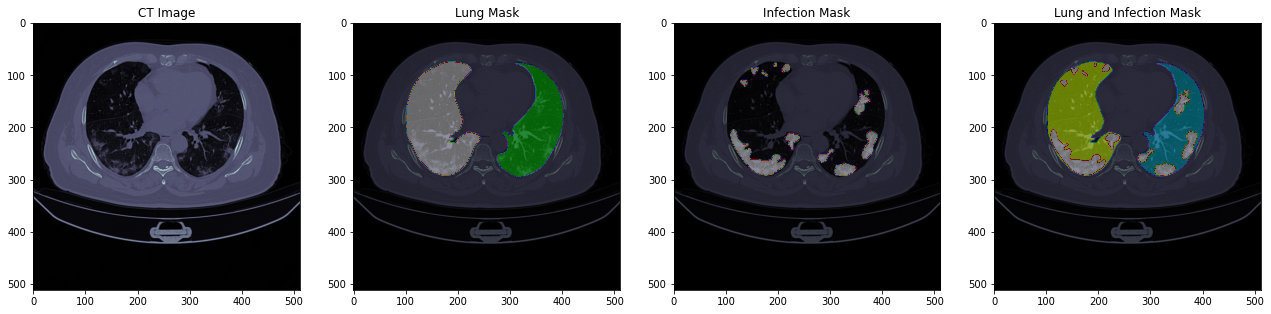

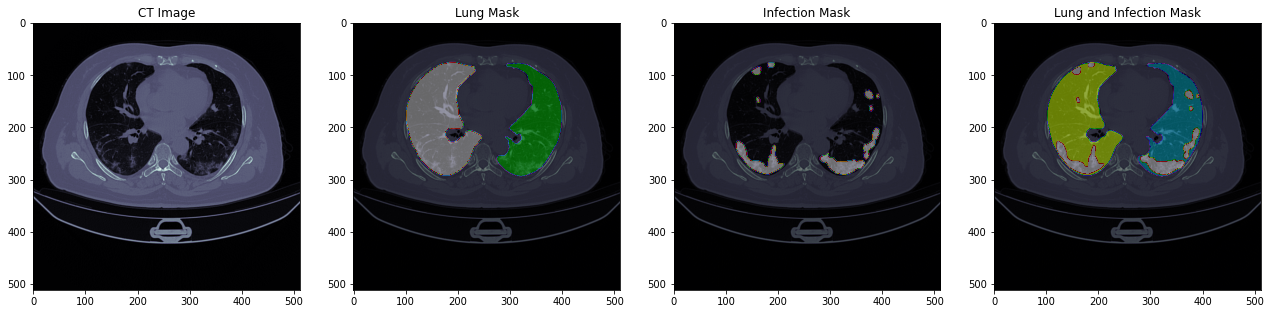

In [42]:
# Examine multiple slices of a ct scan and its annotations
bulk_plot_sample([sample_ct, sample_lung, sample_infe, sample_all], index_list=[100,110,120,130,140,150])